In [145]:
import pickle as pkl

import lxml
import pandas as pd
import numpy as np
#import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow.keras
from tensorflow.keras.datasets import imdb


from tqdm.notebook import tqdm

from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import f1_score

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from ast import literal_eval
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, f1_score
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Activation, Dropout, Conv1D, Flatten, MaxPooling1D,\
                        AveragePooling1D, Concatenate, LeakyReLU, Embedding,\
                        GlobalMaxPooling1D,GlobalAveragePooling1D,GaussianNoise,BatchNormalization,Add
from tensorflow.keras.initializers import glorot_uniform
#from tensorflow.keras.utils.vis_utils import plot_model


from sklearn.metrics import roc_curve, roc_auc_score


import importlib
importlib.reload(tensorflow)

<module 'tensorflow' from '/miniconda/lib/python3.6/site-packages/tensorflow/__init__.py'>

In [2]:
tqdm.pandas()

In [3]:
import tensorflow as tf
with tf.Session() as sess:
    devices = sess.list_devices()

In [4]:
import sys

In [5]:
!{sys.executable} -m list

/miniconda/bin/python: No module named list


In [50]:
drugbank = pd.read_csv('data/intermediate/interactions_preprocessed.csv', chunksize = 7500, iterator = True, converters={"target_gene_encoded_padded": \
                                                                                     lambda x: np.array(x.strip("[]").replace("'","").split(", ")),
                                                                                    "drug_fingerprint_encoded_padded": \
                                                                                    lambda x: np.array(x.strip("[]").replace("'","").split(", "))})

#drugbank = drugbank.sample(7500)

In [127]:
%%time
X_0 = np.array(list(drugbank['target_gene_encoded_padded'])).astype(int) + 1
X_1 = np.array(list(drugbank['drug_fingerprint_encoded_padded'])).astype(int) + 1
Y   = np.array(list(drugbank['Y'])).astype(int)

CPU times: user 15min 38s, sys: 17.4 s, total: 15min 55s
Wall time: 15min 43s


In [128]:
X_final = np.hstack((X_0, X_1))
#X_0_test = np.hstack((X_0_test, X_1_test))

In [129]:
target_length = 30723

X_final = X_final[:, (int(X_final.shape[1]/2) - int(target_length/2)):(int(X_final.shape[1]/2) + int(target_length/2)) + 1]

In [130]:
from tensorflow import keras

use_model = keras.models.load_model('models/CNN_GPU_VGG_rebalance.model')

In [138]:
Y_predicted = []

for X_0_chunck in tqdm(np.array_split(X_final,5000)): 
    
    #print(X_sub.shape)
    Y_predicted.extend(use_model.predict(X_0_chunck[..., np.newaxis]))
    

AttributeError: 'list' object has no attribute 'ravel'

In [141]:
Y_predicted = np.array(Y_predicted).ravel()

In [142]:
Y_predicted

array([9.92322147e-01, 9.76884067e-01, 6.49039298e-02, ...,
       1.22324382e-05, 7.20353186e-01, 1.16940625e-02], dtype=float32)

roc_auc_score:  0.7996401393652749


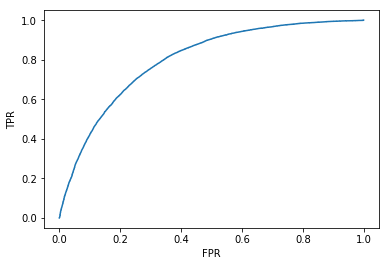

In [147]:
false_positive_rate, true_positive_rate, threshold = roc_curve(Y, Y_predicted)
print('roc_auc_score: ', roc_auc_score(Y, Y_predicted))
import matplotlib.pyplot as plt
plt.plot(false_positive_rate, true_positive_rate)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

In [58]:
model.save('data/models/pure_cnn_gene_only_TF1p6.model')

In [61]:
Y_pred = model.predict(X_0_test[..., np.newaxis])

In [63]:
Y_pred = [1 if i > 0.5 else 0 for i in Y_pred]

In [64]:
tn, fp, fn, tp = confusion_matrix(Y_test, Y_pred).ravel()
cm = confusion_matrix(Y_test, Y_pred)

In [65]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    
    NOTE: Taken from sklearn example
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = [0,1]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

Confusion matrix, without normalization
[[3482  188]
 [ 803 3027]]
Normalized confusion matrix
[[0.94877384 0.05122616]
 [0.20966057 0.79033943]]


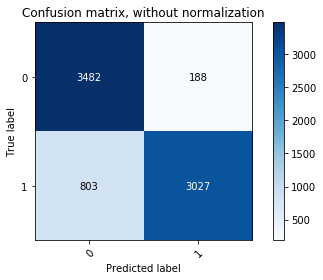

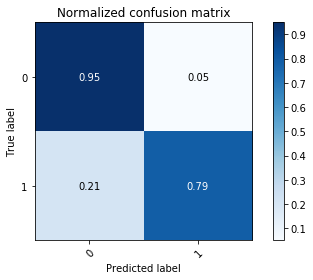

In [66]:
# Plot non-normalized confusion matrix
plot_confusion_matrix(Y_test, Y_pred, classes=[0, 1],
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(Y_test, Y_pred, classes=[0, 1], normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [67]:
f1_score(Y_test, Y_pred)

0.8593328601845281

In [71]:
model.save('models/CNN_GPU_VGG_87p.model')